# Stock Market Predictions with LSTM in Python

In this project I'm planing to do a tool to predict the stock market with Long-Short-Term Memory (LSTM)

In [ ]:
!pip install setuptools yfinance matplotlib pandas scikit-learn tensorflow

In [2]:
# all imports
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Getting the data

To get the data you either have to download it on Kaggle (https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs), generate a API key on Alpha Vantage (https://www.alphavantage.co/) or use yfinance.

Here I'm using the data from Kaggle


In [3]:
# Getting my data from Kaggle

#data_source = 'kaggle'
#data_source = 'alphavantage'
data_source = 'yfinance'

# Amarican Airlines stock market prices
ticker = "NVDA"

if data_source == 'alphavantage':
        print("Load data via Alpha Vantage API...")
        api_key = '' # use your api key here

        # JSON file with all the stock market data for AAL from the last 20 years
        url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

        # save data to this file
        file_to_save = 'stock_market_data-%s.csv'%ticker

        if not os.path.exists(file_to_save):
                try:
                        with urllib.request.urlopen(url_string) as url:
                                data = json.loads(url.read().decode())
                                # extract the data
                                if 'Time Series (Daily)' in data:
                                        data = data['Time Series (Daily)']
                                        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
                                        # parse JSON (it may take some time)
                                        for k, v in data.items():
                                                date = dt.datetime.strptime(k, '%Y-%m-%d')
                                                data_row = [date.date(), float(v['3. low']), float(v['2. high']),
                                                                float(v['4. close']), float(v['1. open'])]
                                                df.loc[len(df)] = data_row
                                        
                                        print(f'Data stored under: {file_to_save}')
                                        df.to_csv(file_to_save, index = False)
                                else:
                                        print('Error: No data received. Checking API key or limit.')
                                        df = pd.DataFrame() # Empty DF as a fallback
                except Exception as e:
                        print(f'Download error: {e}')
                        df = pd.DataFrame()
        else:
                print('File already exists. Loading from CSV...')
                df = pd.read_csv(file_to_save)
elif data_source == 'kaggle':
        print('Loading data from local Kaggle file...')
        # Make sure the 'Stocks' folder and the file exist.
        file_path = os.path.join('Stocks', 'hpq.us.txt')

        if os.path.exists(file_path):
                df = pd.read_csv(file_path, delimiter=',', usecols=['Date','Open','High','Low','Close'])
                print('Data loaded from Kaggle.')
        else:
                print(f'Error: File not found at: {os.path.abspath(file_path)}')
                print('Check if the folder "Stocks" is in the same directory as your notebook.')
                df = pd.DataFrame()
else:
        print(f"Load data for {ticker} via yfinance...")
        df = yf.download(ticker, period="max")
        df = df.reset_index() # Make index column
        df = df[['Date', 'Open', 'High', 'Low', 'Close']] # Enforce the same structure

# Cleanup
# No matter where the data comes from, we process it immediately.
if not df.empty:
        # Ensure that 'Date' is a real date
        df['Date'] = pd.to_datetime(df['Date'])
        # Sort by date
        df = df.sort_values('Date')
        # Reset index
        df = df.reset_index(drop=True)

        print("Data successfully loaded!")
        print(df.head())
else:
        print("ATTENTION: DataFrame is empty. Please check the data source!")

Load data for NVDA via yfinance...


[*********************100%***********************]  1 of 1 completed

Data successfully loaded!
Price        Date      Open      High       Low     Close
Ticker                 NVDA      NVDA      NVDA      NVDA
0      1999-01-22  0.040111  0.044767  0.035575  0.037605
1      1999-01-25  0.040589  0.042021  0.037605  0.041545
2      1999-01-26  0.042021  0.042857  0.037724  0.038321
3      1999-01-27  0.038440  0.039395  0.036291  0.038202
4      1999-01-28  0.038202  0.038440  0.037843  0.038082


### Visualization of the data

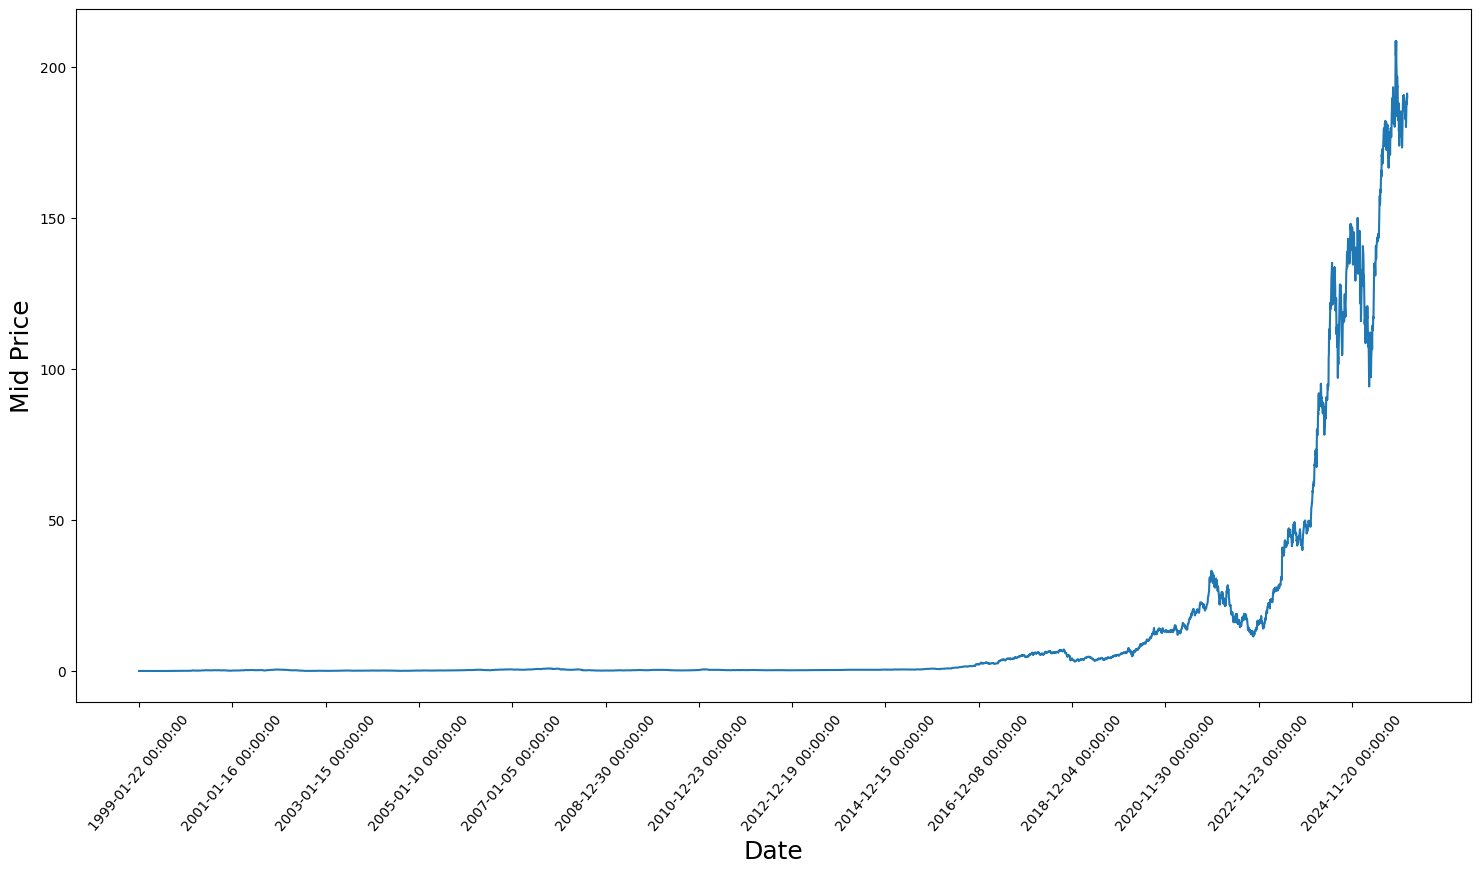

In [4]:
plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500), df['Date'].loc[::500], rotation=50)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()


### Splitting Data into a trainig set and a test set

Mid-price can be calculated by using the average of the highest and lowest recorded prices an a day

In [5]:
high_price = df.loc[:,'High'].to_numpy()
low_price = df.loc[:, 'Low'].to_numpy()
mid_price = (high_price + low_price)/2.0

In [6]:
# Splitting the data into test and training data.
# Dynamically split (80% training, 20% testing)

split_index = int(len(mid_price) * 0.8)

train_data = mid_price[:split_index].reshape(-1, 1)
test_data = mid_price[split_index:].reshape(-1, 1)

print(f"Split successful: {len(train_data)} Training, {len(test_data)} Test")

Split successful: 5437 Training, 1360 Test


### Normalizing the data

To normalize the data I'm using a scalar. And to do so, I'm using MinMaxScalar which scales all the data to be in the region of 0 and 1.

We have to do this because the earlier data will be close to 0 and will not add much value to the learning process.

In [7]:
scaler = MinMaxScaler()

# calculate how much data we actually have
num_train_points = train_data.shape[0]
smoothing_window_size = 2500

# We only run as far as we actually have data.
for di in range(0, num_train_points - smoothing_window_size, smoothing_window_size):
        scaler.fit(train_data[di:di+smoothing_window_size,:])
        train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalize the remaining data
# if statement to check if any data is left
if di + smoothing_window_size < num_train_points:
        scaler.fit(train_data[di+smoothing_window_size:,:])
        train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [8]:
# Flatten training data again for the LSTM
train_data = train_data.reshape(-1)

# Normalize the test data, if there is any
if len(test_data) > 0:
        test_data = scaler.transform(test_data.reshape(-1, 1)).reshape(-1)

print("Data is normalized and ready for training!")
print(f"Shape Train: {train_data.shape}; Shape Test: {test_data.shape}")

Data is normalized and ready for training!
Shape Train: (5437,); Shape Test: (1360,)


In [9]:
EMA = 0.0
gamma = 0.1
for i in range(len(train_data)):
        EMA = gamma*train_data[i] + (1-gamma)*EMA
        train_data[i] = EMA

all_mid_data = np.concatenate([train_data, test_data], axis = 0)

### Data augmentation

In [11]:
class DataGeneratorSeq(object):
        def __init__(self, prices, batch_size, num_unroll):
                self._prices = prices
                self._prices_length = len(self._prices) - num_unroll
                self._batch_size = batch_size
                self._num_unroll = num_unroll
                self._segments = self._prices_length // self._batch_size
                self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
        def next_batch(self):

                batch_data = np.zeros((self._batch_size, self._num_unroll, 1), dtype=np.float32)
                batch_labels = np.zeros((self._batch_size, 1), dtype=np.float32)

                for i in range(self._batch_size):
                        start_idx = self._cursor[i]
                        end_idx = start_idx + self._num_unroll

                        batch_data[i, :, 0] = self._prices[start_idx:end_idx]
                        batch_labels[i, 0] = self._prices[end_idx]

                        self._cursor[i] = (self._cursor[i] + 1) % self._prices_length

                return batch_data, batch_labels

        def reset_indices(self):
                for i in range(self._batch_size):
                        self._cursor[i] = np.random.randint(0, min((i+1)*self._segments,self._prices_length-1))
        
dg = DataGeneratorSeq(train_data, 5, 5)
u_data, u_labels = dg.next_batch()

for ui,(dat, lbl) in enumerate(zip(u_data, u_labels)):
        print('\n\nUnrolled index %d'%ui)
        dat_ind = dat
        lbl_ind = lbl
        print('\tInputs: ',dat )
        print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [[0.00094764]
 [0.00175903]
 [0.00254464]
 [0.00296806]
 [0.00338373]]

	Output: [0.00365408]


Unrolled index 1
	Inputs:  [[0.12307142]
 [0.1252157 ]
 [0.1274112 ]
 [0.12963504]
 [0.13202162]]

	Output: [0.13503277]


Unrolled index 2
	Inputs:  [[0.8374865 ]
 [0.83885044]
 [0.8377008 ]
 [0.83584267]
 [0.8388185 ]]

	Output: [0.84421927]


Unrolled index 3
	Inputs:  [[0.02237661]
 [0.02235277]
 [0.0224411 ]
 [0.02255829]
 [0.02269326]]

	Output: [0.0227967]


Unrolled index 4
	Inputs:  [[0.10235032]
 [0.10218521]
 [0.10215038]
 [0.10195801]
 [0.1015346 ]]

	Output: [0.10124454]


### Defining hyperparameters

In [12]:
initial_learning_rate = 0.1
decay_steps = 1000 # After how many steps should the rate decrease
decay_rate = 0.97 # By what factor (e.g., to 97% of the previous rate)

# Create the Schedule object
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True # If True, the rate drops abruptly
)
# Create the optimizer and pass the schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### Defining the Model Architecture

In [13]:
# Hyperparameters
D = 1 # just 1 dimension
num_unrollings = 50 # num of days to look back
batch_size = 500 # num of samples per training step
num_nodes = [128, 64, 32] # hidden nodes in each LSTM layer
dropout = 0.2 # Dropout rate for regularization

model = Sequential()

# Adding LSTM layers
model.add(LSTM(num_nodes[0], return_sequences=True, input_shape=(num_unrollings, D)))
model.add(Dropout(dropout))

model.add(LSTM(num_nodes[1], return_sequences=True))
model.add(Dropout(dropout))

model.add(LSTM(num_nodes[2], return_sequences=False))
model.add(Dropout(dropout))

# output Layer
model.add(Dense(1))

model.compile(optimizer=optimizer, loss='mean_squared_error')

print("Model Architecture defined and compiled")
model.summary()

Model Architecture defined and compiled


/Users/louis/VSCode/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,417 (501.63 KB)

 Trainable params: 128,417 (501.63 KB)

 Non-trainable params: 0 (0.00 B)

### Training the LSTM Model

In [15]:
epochs = 30
steps_per_epoch = 20

dg = DataGeneratorSeq(train_data, batch_size, num_unrollings)
loss_history = []

print("Start training")

for epoch in range(epochs):
        epoch_loss = 0
        for step in range(steps_per_epoch):
                x_batch, y_batch = dg.next_batch()

                loss = model.train_on_batch(x_batch, y_batch)

                epoch_loss += loss
        
        avg_loss = epoch_loss / steps_per_epoch

        loss_history.append(avg_loss)
        print(f"Epoche {epoch+1}/{epochs} | Loss: {avg_loss:.5f}")

print("Finished training")

Start training
Epoche 1/30 | Loss: 0.12942
Epoche 2/30 | Loss: 0.12627
Epoche 3/30 | Loss: 0.12338
Epoche 4/30 | Loss: 0.12074
Epoche 5/30 | Loss: 0.11829
Epoche 6/30 | Loss: 0.11603
Epoche 7/30 | Loss: 0.11393
Epoche 8/30 | Loss: 0.11197
Epoche 9/30 | Loss: 0.11015
Epoche 10/30 | Loss: 0.10844
Epoche 11/30 | Loss: 0.10683
Epoche 12/30 | Loss: 0.10532
Epoche 13/30 | Loss: 0.10390
Epoche 14/30 | Loss: 0.10257
Epoche 15/30 | Loss: 0.10131
Epoche 16/30 | Loss: 0.10012
Epoche 17/30 | Loss: 0.09900
Epoche 18/30 | Loss: 0.09795
Epoche 19/30 | Loss: 0.09697
Epoche 20/30 | Loss: 0.09607
Epoche 21/30 | Loss: 0.09522
Epoche 22/30 | Loss: 0.09443
Epoche 23/30 | Loss: 0.09367
Epoche 24/30 | Loss: 0.09295
Epoche 25/30 | Loss: 0.09228
Epoche 26/30 | Loss: 0.09163
Epoche 27/30 | Loss: 0.09101
Epoche 28/30 | Loss: 0.09042
Epoche 29/30 | Loss: 0.08986
Epoche 30/30 | Loss: 0.08933
Finished training


### Visualizing Training Progress (Loss)

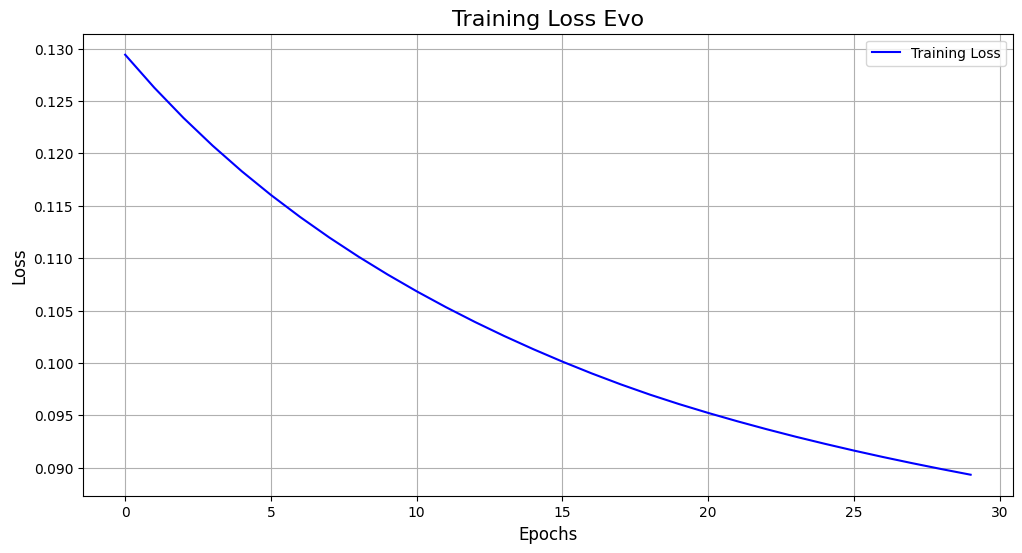

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(loss_history, color='blue', label='Training Loss')
plt.title('Training Loss Evo', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()